In [17]:

import nibabel as nib
import matplotlib.pyplot as plt

file_path = "../dataset/REC-0.nii"  # replace with your file path
img = nib.load(file_path)

In [18]:
data = img.get_fdata()


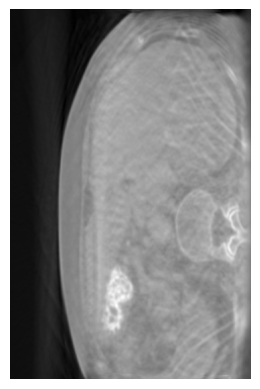

In [19]:
slice_idx = data.shape[2] // 2
plt.imshow(data[:, :, slice_idx], cmap="gray")
plt.axis('off')
plt.show()